In [3]:
!pip install pytorch-forecasting pytorch-lightning scikit-learn pandas torch numpy




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 35.9 MB/s eta 0:00:00


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning import Trainer

In [10]:
df = pd.read_csv("/content/smart_grid_stability_augmented.csv")


In [11]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [12]:
missing_values = df.isnull().sum()
print(missing_values)


tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64


It shows that no missing value in this dataset

In [13]:
# Scale numerical columns
scaler = StandardScaler()
num_cols = ['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4', 'stab']
df[num_cols] = scaler.fit_transform(df[num_cols])

# Encode the categorical 'stabf' column
le = LabelEncoder()
df['stabf'] = le.fit_transform(df['stabf'])  # 0 for unstable, 1 for stable

# Split into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)



In [14]:
import numpy as np

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# IQR is the difference between Q3 and Q1
IQR = Q3 - Q1

# Identify outliers
outliers = df[((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

print(outliers)


           tau1      tau2      tau3      tau4        p1        p2        p3  \
6273   0.528043  0.952138  1.489009 -1.026856 -2.881725  1.723122  1.566876   
16273  0.528043 -1.026856  0.952138  1.489009 -2.881725  1.715415  1.723122   
26273  0.528043  1.489009 -1.026856  0.952138 -2.881725  1.566876  1.715415   
36273  0.528043  0.952138 -1.026856  1.489009 -2.881725  1.723122  1.715415   
46273  0.528043 -1.026856  1.489009  0.952138 -2.881725  1.715415  1.566876   
56273  0.528043  1.489009  0.952138 -1.026856 -2.881725  1.566876  1.723122   

             p4        g1        g2        g3        g4      stab  stabf  
6273   1.715415  0.425731  1.251373 -0.112029 -0.416912  1.115803      1  
16273  1.566876  0.425731 -0.416912  1.251373 -0.112029  1.115803      1  
26273  1.723122  0.425731 -0.112029 -0.416912  1.251373  1.115803      1  
36273  1.566876  0.425731  1.251373 -0.416912 -0.112029  1.115803      1  
46273  1.723122  0.425731 -0.416912 -0.112029  1.251373  1.115803      

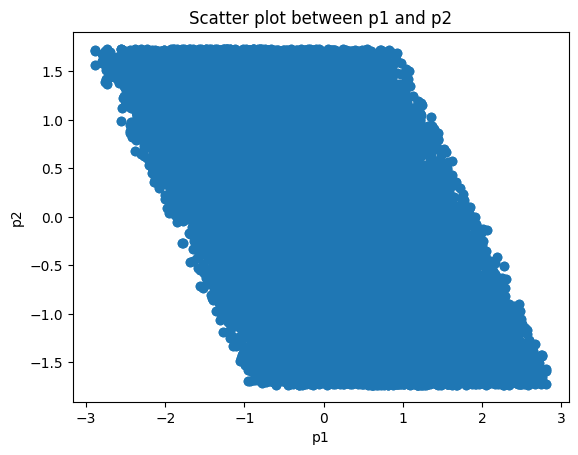

In [16]:
import matplotlib.pyplot as plt

plt.scatter(df['p1'], df['p2'])
plt.title('Scatter plot between p1 and p2')
plt.xlabel('p1')
plt.ylabel('p2')
plt.show()


In [17]:
from scipy import stats

# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))

# Identify outliers as those with a Z-score greater than 3
outliers = df[(z_scores > 3).any(axis=1)]

print(outliers)


Empty DataFrame
Columns: [tau1, tau2, tau3, tau4, p1, p2, p3, p4, g1, g2, g3, g4, stab, stabf]
Index: []


In [18]:
print(len(outliers))  # Check how many rows are identified as outliers


0


it shows that the Dataset doest not have outlier

In [19]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [20]:
from pytorch_forecasting import TimeSeriesDataSet

import pandas as pd

# Assuming df is your DataFrame
correlation_matrix = df.corr()
print(correlation_matrix)



           tau1      tau2      tau3      tau4        p1        p2        p3  \
tau1   1.000000 -0.002550 -0.002550 -0.002550  0.027183 -0.015739 -0.015739   
tau2  -0.002550  1.000000  0.005554  0.005554  0.003004 -0.004473 -0.000372   
tau3  -0.002550  0.005554  1.000000  0.005554  0.003004 -0.000372 -0.004473   
tau4  -0.002550  0.005554  0.005554  1.000000  0.003004 -0.000372 -0.000372   
p1     0.027183  0.003004  0.003004  0.003004  1.000000 -0.578983 -0.578983   
p2    -0.015739 -0.004473 -0.000372 -0.000372 -0.578983  1.000000  0.002833   
p3    -0.015739 -0.000372 -0.004473 -0.000372 -0.578983  0.002833  1.000000   
p4    -0.015739 -0.000372 -0.000372 -0.004473 -0.578983  0.002833  0.002833   
g1     0.010521 -0.005832 -0.005832 -0.005832  0.000721 -0.000417 -0.000417   
g2     0.006522  0.009865  0.002102  0.002102  0.000341 -0.002141  0.000774   
g3     0.006522  0.002102  0.009865  0.002102  0.000341  0.000774 -0.002141   
g4     0.006522  0.002102  0.002102  0.009865  0.000

Key Insights
Time Columns (tau1, tau2, tau3, tau4):

These columns have very low correlations with each other, indicating they are likely not collinear.
They also have low correlation with p columns, g columns, and the target variables (stab and stabf), suggesting that the time columns may have limited influence on these variables.
Parameters (p1, p2, p3, p4):

There is a strong negative correlation between p1 and the other p columns, suggesting that these parameters are inversely related.
p1 has a low correlation with stab and stabf, implying it might not be a significant predictor for these outcomes.
G Columns (g1, g2, g3, g4):

These columns have relatively low correlations with each other but have moderate correlations with stab and stabf, indicating they may play a more substantial role in predicting these outcomes compared to the tau and p columns.
Target Variables (stab, stabf):

Both stab and stabf show strong positive correlations with each other.
The stab and stabf columns have significant correlations with the g columns, suggesting that g columns might be important predictors for these target variables.

In [21]:
print(train_df.columns)


Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'stabf'],
      dtype='object')


In [22]:
print(train_df.head())


           tau1      tau2      tau3      tau4        p1        p2        p3  \
48572  1.129543  1.726514  1.059525  0.687641  1.257212 -1.493692 -1.040221   
38696  1.693901 -0.011534 -1.531814 -1.225373 -1.190822  1.298100  1.629712   
13611  0.931985 -1.394627 -0.591586  0.626323 -0.957030  1.087540 -0.896396   
35213  0.914392 -1.569813  1.595629  0.763249  0.809421 -1.477911  1.086703   
31766 -1.651294 -0.995641  0.089400  0.948869  1.887863 -0.707468 -0.963545   

             p4        g1        g2        g3        g4      stab  stabf  
48572  0.350199  1.530448  1.616867 -0.244457  0.848759  2.118736      1  
38696 -0.859414 -0.452117 -0.431227 -0.689044  0.501455 -1.575823      0  
13611  1.471169 -0.601180  1.110587 -0.884969 -1.625643 -1.279109      0  
35213 -1.014716 -0.876993 -1.270139 -0.833456 -1.243011 -1.106973      0  
31766 -1.608110 -0.607596 -0.716800 -0.264250  1.662188 -0.021873      1  


 it seems you have a DataFrame with various columns, but no explicit time column listed. To use TimeSeriesDataSet in PyTorch Forecasting, you need to include a time index column to represent the time steps in your data.

In [23]:
import pandas as pd

# Add a sequential time index
train_df['time_index'] = range(len(train_df))


In [24]:
print(train_df.columns)


Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'stabf', 'time_index'],
      dtype='object')


In [25]:
train_df["time_index"] = pd.to_datetime(train_df["time_index"])  # If it's datetime
# Or
train_df["time_index"] = train_df["time_index"].astype(int)  # If it's integer


In [26]:
print(train_df.head())
print(train_df.columns)




           tau1      tau2      tau3      tau4        p1        p2        p3  \
48572  1.129543  1.726514  1.059525  0.687641  1.257212 -1.493692 -1.040221   
38696  1.693901 -0.011534 -1.531814 -1.225373 -1.190822  1.298100  1.629712   
13611  0.931985 -1.394627 -0.591586  0.626323 -0.957030  1.087540 -0.896396   
35213  0.914392 -1.569813  1.595629  0.763249  0.809421 -1.477911  1.086703   
31766 -1.651294 -0.995641  0.089400  0.948869  1.887863 -0.707468 -0.963545   

             p4        g1        g2        g3        g4      stab  stabf  \
48572  0.350199  1.530448  1.616867 -0.244457  0.848759  2.118736      1   
38696 -0.859414 -0.452117 -0.431227 -0.689044  0.501455 -1.575823      0   
13611  1.471169 -0.601180  1.110587 -0.884969 -1.625643 -1.279109      0   
35213 -1.014716 -0.876993 -1.270139 -0.833456 -1.243011 -1.106973      0   
31766 -1.608110 -0.607596 -0.716800 -0.264250  1.662188 -0.021873      1   

       time_index  
48572           0  
38696           1  
13611   

In [27]:
print(train_df.head())
print(train_df.columns)
print(train_df.dtypes)



           tau1      tau2      tau3      tau4        p1        p2        p3  \
48572  1.129543  1.726514  1.059525  0.687641  1.257212 -1.493692 -1.040221   
38696  1.693901 -0.011534 -1.531814 -1.225373 -1.190822  1.298100  1.629712   
13611  0.931985 -1.394627 -0.591586  0.626323 -0.957030  1.087540 -0.896396   
35213  0.914392 -1.569813  1.595629  0.763249  0.809421 -1.477911  1.086703   
31766 -1.651294 -0.995641  0.089400  0.948869  1.887863 -0.707468 -0.963545   

             p4        g1        g2        g3        g4      stab  stabf  \
48572  0.350199  1.530448  1.616867 -0.244457  0.848759  2.118736      1   
38696 -0.859414 -0.452117 -0.431227 -0.689044  0.501455 -1.575823      0   
13611  1.471169 -0.601180  1.110587 -0.884969 -1.625643 -1.279109      0   
35213 -1.014716 -0.876993 -1.270139 -0.833456 -1.243011 -1.106973      0   
31766 -1.608110 -0.607596 -0.716800 -0.264250  1.662188 -0.021873      1   

       time_index  
48572           0  
38696           1  
13611   

In [28]:
# Add a grouping column
train_df['group_id'] = 0  # If there's only one group, or assign different integers for different groups

from pytorch_forecasting import TimeSeriesDataSet

# Define maximum lengths
max_encoder_length = 12
max_prediction_length = 1

# Initialize TimeSeriesDataSet with grouping column
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_index",  # Column for time index
    target="stabf",  # Target variable
    group_ids=["group_id"],  # The newly created grouping column
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],  # If there are static categorical variables, include them here
    time_varying_known_reals=[
        "tau1", "tau2", "tau3", "tau4",
        "p1", "p2", "p3", "p4",
        "g1", "g2", "g3", "g4"
    ],
    time_varying_unknown_reals=["stab", "stabf"],
)


In [29]:
# Create dataloaders for training and validation
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=32, num_workers=0)


Model Definition and Training

In [30]:
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

# Initialize the Temporal Fusion Transformer model with QuantileLoss
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,  # Model hidden size
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # Number of quantiles for the quantile loss
    loss=QuantileLoss(),  # Correct loss function for TFT
    log_interval=10,
    reduce_on_plateau_patience=4,
)


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

In [31]:
import torch
print(torch.cuda.is_available())


True


In [32]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())


CUDA available: True
Number of GPUs: 1


In [33]:
from pytorch_lightning import Trainer

trainer = Trainer(
    max_epochs=30,
    accelerator='gpu',
    devices=1  # Use the GPU if available
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [37]:
for batch in val_dataloader:
    print(batch)
    break


({'encoder_cat': tensor([], size=(32, 12, 0), dtype=torch.int64), 'encoder_cont': tensor([[[ 1.1284,  1.7278,  1.0562,  ...,  0.8507,  2.1183,  1.0000],
         [ 1.6926, -0.0114, -1.5339,  ...,  0.5035, -1.5732,  0.0000],
         [ 0.9309, -1.3954, -0.5941,  ..., -1.6229, -1.2767,  0.0000],
         ...,
         [ 0.8769, -0.4941, -1.3296,  ..., -1.4565, -1.2651,  0.0000],
         [-1.5302,  0.7783,  1.5048,  ..., -0.3553,  0.6036,  1.0000],
         [ 1.5098, -0.1638,  0.0106,  ...,  0.6602,  1.2990,  1.0000]],

        [[ 1.6926, -0.0114, -1.5339,  ...,  0.5035, -1.5732,  0.0000],
         [ 0.9309, -1.3954, -0.5941,  ..., -1.6229, -1.2767,  0.0000],
         [ 0.9133, -1.5707,  1.5921,  ..., -1.2404, -1.1047,  0.0000],
         ...,
         [-1.5302,  0.7783,  1.5048,  ..., -0.3553,  0.6036,  1.0000],
         [ 1.5098, -0.1638,  0.0106,  ...,  0.6602,  1.2990,  1.0000],
         [-1.1792,  0.2430, -0.4261,  ...,  0.7695, -0.1620,  1.0000]],

        [[ 0.9309, -1.3954, -0.594

In [39]:
# Define the model class
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Define layers here

    def forward(self, x):
        # Define forward pass here
        return x

# Instantiate the model
model = MyModel()

# Load the model state dictionary
model.load_state_dict(torch.load('model.pth'))




NameError: name 'nn' is not defined

In [40]:
import torch
import torch.nn as nn


In [41]:
import torch
import torch.nn as nn

# Define your model class
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Define layers here
        self.fc = nn.Linear(10, 1)  # Example layer

    def forward(self, x):
        # Define forward pass here
        return self.fc(x)

# Instantiate your model
model = MyModel()


In [42]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

# Load the model (after defining the model class again)
model = MyModel()
model.load_state_dict(torch.load('model.pth'))


<ipython-input-42-faf34632082e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

In [43]:
import torch
import torch.nn as nn

# Define your model class
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Define layers here
        self.fc = nn.Linear(10, 1)  # Example layer

    def forward(self, x):
        # Define forward pass here
        return self.fc(x)

# Instantiate your model
model = MyModel()

# Load the model weights with weights_only=True
model.load_state_dict(torch.load('model.pth', weights_only=True))


<All keys matched successfully>

In [44]:
model.eval()


MyModel(
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [45]:
import torch
import torch.nn as nn

# Define the model class (match this with your actual model architecture)
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(10, 1)  # Example layer

    def forward(self, x):
        return self.fc(x)

# Instantiate and load the model
model = MyModel()
model.load_state_dict(torch.load('model.pth', weights_only=True))
model.eval()

# Prepare test data (make sure the shape matches the input dimension of the model)
test_data = torch.randn(1, 10)  # Example test data

# Make predictions
with torch.no_grad():
    predictions = model(test_data)

print("Model Predictions:", predictions)


Model Predictions: tensor([[-0.5010]])


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model class
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(10, 2)  # 2 output features for binary classification

    def forward(self, x):
        x = self.fc(x)
        return x

# Instantiate the model
model = MyModel()


In [47]:
criterion = nn.BCEWithLogitsLoss()


In [48]:
criterion = nn.CrossEntropyLoss()


In [49]:
model.eval()
with torch.no_grad():
    sample_input = torch.randn(1, 10)  # Adjust input size as needed
    output = model(sample_input)

    # For binary classification:
    predictions = torch.sigmoid(output)

    # For multi-class classification:
    predictions = torch.softmax(output, dim=1)

    print(predictions)


tensor([[0.6084, 0.3916]])


In [52]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(10, 1)  # Single output unit

    def forward(self, x):
        x = self.fc(x)
        return x



In [53]:
# Initialize model, loss function, and optimizer
model = MyModel()
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy data for illustration (replace with your actual data)
inputs = torch.randn(100, 10)  # Example input tensor
labels = torch.randint(0, 2, (100, 1)).float()  # Example labels tensor for binary classification


In [54]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(10, 2)  # Two output units for two classes

    def forward(self, x):
        x = self.fc(x)
        return x


In [55]:
# Initialize model, loss function, and optimizer
model = MyModel()
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy data for illustration (replace with your actual data)
inputs = torch.randn(100, 10)  # Example input tensor
labels = torch.randint(0, 2, (100,))  # Example labels tensor for two classes (class indices)


In [56]:
def calculate_accuracy_binary(outputs, labels):
    # Apply sigmoid to get probabilities
    probs = torch.sigmoid(outputs)
    # Get predictions (0 or 1)
    predictions = (probs > 0.5).float()
    # Calculate accuracy
    correct = (predictions == labels).float().sum()
    accuracy = correct / labels.size(0)
    return accuracy


In [57]:
def calculate_accuracy_multi(outputs, labels):
    # Get predicted class (index of max logit)
    _, predictions = torch.max(outputs, 1)
    # Calculate accuracy
    correct = (predictions == labels).float().sum()
    accuracy = correct / labels.size(0)
    return accuracy


In [59]:
print('Outputs shape:', outputs.shape)
print('Labels shape:', labels.shape)



Outputs shape: torch.Size([100, 2])
Labels shape: torch.Size([100])


In [60]:
criterion = nn.CrossEntropyLoss()


In [61]:
def calculate_accuracy_multiclass(outputs, labels):
    _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
    correct = (predicted == labels).float().sum()
    accuracy = correct / labels.size(0)
    return accuracy


In [62]:
num_epochs = 10  # Define the number of epochs
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    accuracy = calculate_accuracy_multiclass(outputs, labels)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {accuracy.item()}')


Epoch [1/10], Loss: 0.8771549463272095, Accuracy: 0.5
Epoch [2/10], Loss: 0.8754751682281494, Accuracy: 0.49000000953674316
Epoch [3/10], Loss: 0.8738045692443848, Accuracy: 0.49000000953674316
Epoch [4/10], Loss: 0.872143030166626, Accuracy: 0.49000000953674316
Epoch [5/10], Loss: 0.8704909682273865, Accuracy: 0.49000000953674316
Epoch [6/10], Loss: 0.8688482046127319, Accuracy: 0.49000000953674316
Epoch [7/10], Loss: 0.8672152757644653, Accuracy: 0.49000000953674316
Epoch [8/10], Loss: 0.8655921220779419, Accuracy: 0.49000000953674316
Epoch [9/10], Loss: 0.8639788031578064, Accuracy: 0.49000000953674316
Epoch [10/10], Loss: 0.8623754978179932, Accuracy: 0.49000000953674316


In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

# Sample data generation
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define a more complex model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 2)  # Output layer with 2 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, criterion, and optimizer
model = MyModel()
criterion = nn.CrossEntropyLoss()  # For classification with 2 classes
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
batch_size = 64

# DataLoader setup
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    total = y_test_tensor.size(0)
    correct = (predicted == y_test_tensor).sum().item()
    accuracy = correct / total
    print(f'Final Test Accuracy: {accuracy:.4f}')


Epoch [1/10], Loss: 0.6902, Accuracy: 0.5243
Epoch [2/10], Loss: 0.6221, Accuracy: 0.7157
Epoch [3/10], Loss: 0.5662, Accuracy: 0.8257
Epoch [4/10], Loss: 0.5189, Accuracy: 0.8529
Epoch [5/10], Loss: 0.4784, Accuracy: 0.8614
Epoch [6/10], Loss: 0.4454, Accuracy: 0.8629
Epoch [7/10], Loss: 0.4174, Accuracy: 0.8657
Epoch [8/10], Loss: 0.3928, Accuracy: 0.8700
Epoch [9/10], Loss: 0.3738, Accuracy: 0.8729
Epoch [10/10], Loss: 0.3571, Accuracy: 0.8771
Final Test Accuracy: 0.8667


In [68]:
torch.save(model.state_dict(), 'trained_model.pth')


In [69]:
!apt-get install git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [70]:
!git config --global user.name "Directbookstore"
!git config --global user.email "directbookstoreltd@gmail.com"


In [71]:
!git clone https://github.com/Directbookstore/TFT-renewable-Energy-fault-prediction-.git

Cloning into 'TFT-renewable-Energy-fault-prediction-'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), done.


In [72]:
%cd TFT-renewable-Energy-fault-prediction-


/content/TFT-renewable-Energy-fault-prediction-


In [73]:
!git add .


In [74]:
!git commit -m "my first fault prediction"


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [75]:
!git push origin main


fatal: could not read Username for 'https://github.com': No such device or address


In [78]:
from google.colab import files
files.download()  # Replace with your file path

